In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os as os
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2



Image Preprosessing and Visualization

Found 1404 files belonging to 2 classes.
['Healthy', 'Parkinson']


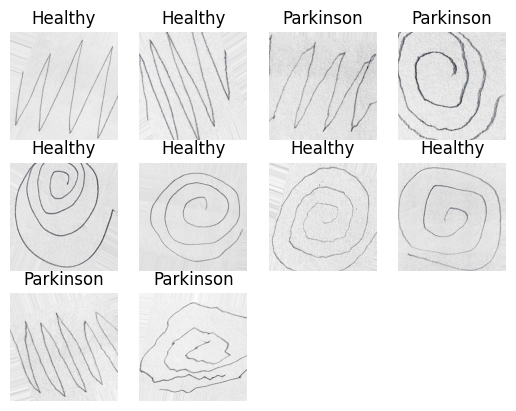

In [4]:



dataset_path= '/content/drive/MyDrive/drawings'
dataset_Healthy = '/content/drive/MyDrive/drawings/Healthy'
dataset_Parkinson = '/content/drive/MyDrive/drawings/Parkinson'


raw_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True ,
    image_size=(256, 256),
    batch_size=32
)


class_names = raw_dataset.class_names
print(class_names)
for images, labels in raw_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data Augmentation using Image Generator

In [ ]:
#augmentor = ImageDataGenerator(
#    rotation_range=30,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    zoom_range=0.2,
#    shear_range=0.1,
#    horizontal_flip=True,
#    fill_mode='nearest'
#)

# Data Generator
#generator_healthy = augmentor.flow_from_directory(
#    '/content/drive/MyDrive/drawings',
#    classes=["Healthy"],
#    target_size=(256, 256),
#    batch_size=1,
#    class_mode=None,
#    shuffle= False,
#    save_to_dir='/content/drive/MyDrive/drawings/Healthy',
#    save_prefix='aug_healthy',
#    save_format='png'
#)

#generator_parkinson = augmentor.flow_from_directory(
#    '/content/drive/MyDrive/drawings',
#    classes=["Parkinson"],
#    target_size=(256, 256),
#    batch_size=1,
#    class_mode=None,
#    shuffle= False,
#    save_to_dir='/content/drive/MyDrive/drawings/Parkinson',
#    save_prefix='aug_parkinson',
#    save_format='png'
#)


#num_augmented = 600
#for i in range(num_augmented):
#    next(generator_healthy)
#    next(generator_parkinson)

Found 102 images belonging to 1 classes.
Found 102 images belonging to 1 classes.


Validation-Training Split (70-30)

In [5]:
ds_train= tf.keras.preprocessing.image_dataset_from_directory(dataset_path,
                                                              validation_split=0.3 ,
                                                              subset="training" ,
                                                              shuffle=True,
                                                              seed=123,
                                                              image_size=(128,128),
                                                              batch_size=32)

ds_validation= tf.keras.preprocessing.image_dataset_from_directory(dataset_path,
                                                              validation_split=0.3 ,
                                                              subset="validation" ,
                                                              shuffle=True,
                                                              seed =123,
                                                              image_size=(128,128),
                                                              batch_size=32)

#Get class names
class_names = ds_train.class_names
print (class_names)



Found 1404 files belonging to 2 classes.
Using 983 files for training.
Found 1404 files belonging to 2 classes.
Using 421 files for validation.
['Healthy', 'Parkinson']


Preprosesing layer for real-time Data Augmentation using Sequential(Optional)

In [ ]:
#preprocessing_layer = tf.keras.Sequential([
#    tf.keras.layers.Rescaling(1./255),
#    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#    tf.keras.layers.RandomRotation(0.1),
#    tf.keras.layers.RandomZoom(0.1),
#    tf.keras.layers.RandomContrast(0.1),
#    tf.keras.layers.RandomTranslation(0.1, 0.1)
#])

#ds_train = ds_train.map(lambda x, y: (preprocessing_layer(x), y))





#Data Normalization
ds_train = ds_train.map(lambda x, y: (x / 255.0, y))
ds_validation = ds_validation.map(lambda x, y: (x / 255.0, y))


In [ ]:
#Data Pipeline Optimization
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)

Sequential Cnn Model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(72, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(16, activation='relu',kernel_regularizer=l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer= Adam(learning_rate = 0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 72)     │        41,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 72)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       225,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,417 (1.10 MB)

 Trainable params: 287,225 (1.10 MB)

 Non-trainable params: 192 (768.00 B)

Model Training and Validation

In [ ]:
#Training
history = model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=30
)

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4870 - loss: 0.9182 - val_accuracy: 0.5083 - val_loss: 0.7248
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5220 - loss: 0.7947 - val_accuracy: 0.5083 - val_loss: 0.7249
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5129 - loss: 0.7775 - val_accuracy: 0.4846 - val_loss: 0.7250
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5434 - loss: 0.7232 - val_accuracy: 0.4774 - val_loss: 0.7253
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5318 - loss: 0.7378 - val_accuracy: 0.4869 - val_loss: 0.7253
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5239 - loss: 0.7304 - val_accuracy: 0.4893 - val_loss: 0.7253
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5640 - loss: 0.7161 - val_accuracy: 0.4988 - val_loss: 0.7252
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5616 - loss: 0.7100 - val_accuracy: 0.4941 - val_loss:

Saving CNN Sequential

In [ ]:
model.save('cnn_model.keras')

Plotting Accuracy and Loss

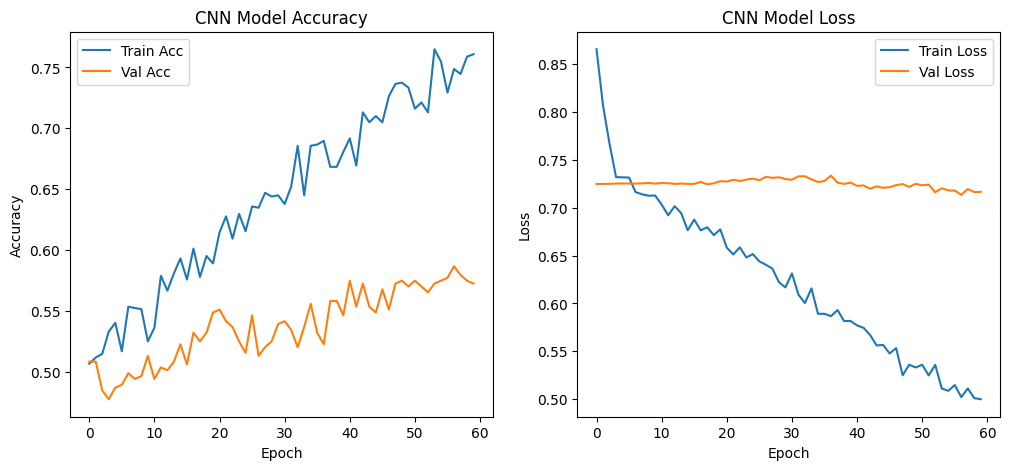

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Cnn model Evaluation

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.5581 - loss: 0.7246
Validation Accuracy: 57.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


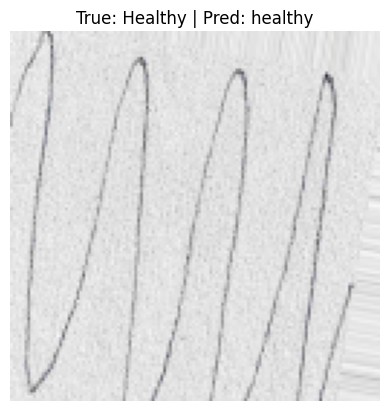

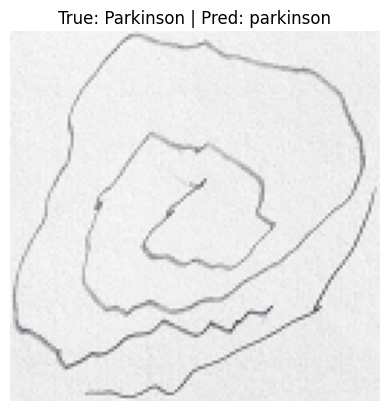

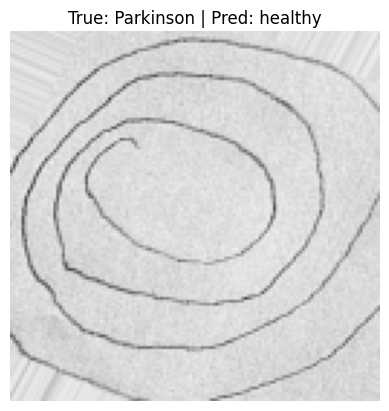

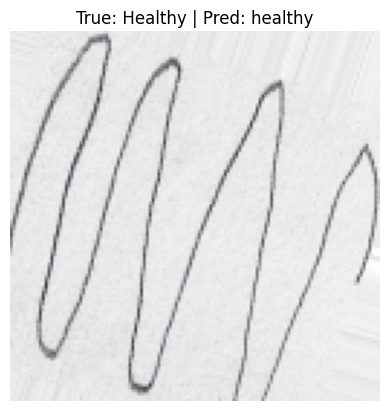

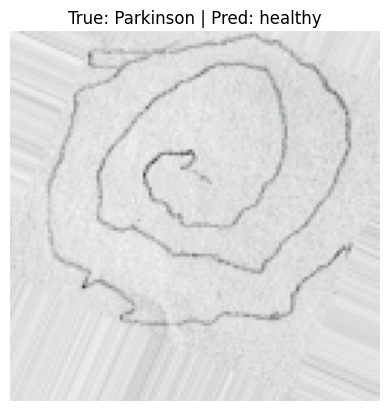

In [ ]:
loss, accuracy = model.evaluate(ds_validation)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

for images, labels in ds_validation.take(1):
    predictions = model.predict(images)
    for i in range(5):
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]} | Pred: {'parkinson' if predictions[i] > 0.6 else 'healthy'}")
        plt.axis('off')
        plt.show()

Machine Learning Model(Random Forest)

Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
#Reduced size for Machine Learning
img_size =64
x=[]
y=[]

Data Preprocesing

In [6]:
for label in ['Healthy', 'Parkinson']:
    label_path = os.path.join(dataset_path, label)
    for filename in os.listdir(label_path):
        filepath = os.path.join(label_path, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        x.append(img.flatten())
        y.append(label)

X=np.array(x)
Y=np.array(y)
print (X.shape)
print (Y.shape)

(1404, 4096)
(1404,)


In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y)


Data Split(70-30) And Training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=120, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120, random_state=42)

In [9]:
y_pred = rf.predict(X_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


 Accuracy: 0.5995260663507109

 Classification Report:
               precision    recall  f1-score   support

     Healthy       0.60      0.60      0.60       211
   Parkinson       0.60      0.60      0.60       211

    accuracy                           0.60       422
   macro avg       0.60      0.60      0.60       422
weighted avg       0.60      0.60      0.60       422



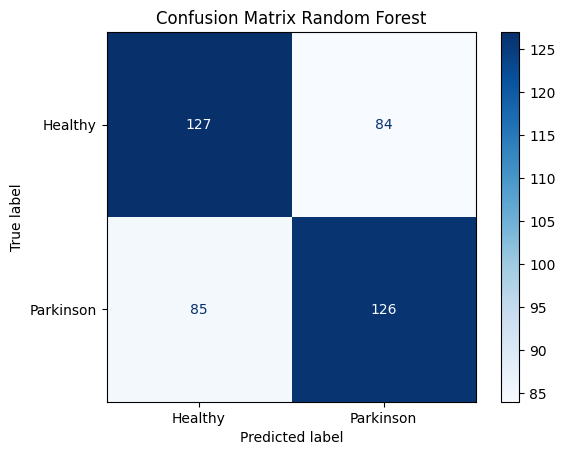

In [10]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Parkinson'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Random Forest")
plt.show()

In [ ]:
New_Model = keras.models.load_model('cnn_model.keras')
New_Model.evaluate(ds_validation)
New_Model.summary()

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.5577 - loss: 0.7253


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 72)     │        41,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 72)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       225,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 861,869 (3.29 MB)

 Trainable params: 287,225 (1.10 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 574,452 (2.19 MB)

In [ ]:
conv_layer = New_Model.layers[0]
weights, biases = conv_layer.get_weights()
print(weights.shape)
print (biases.shape)